# Fine-Tuning a Hugging Face Model for Sentiment Analysis

In this notebook, we will walk through the process of fine-tuning a pre-trained model from Hugging Face for sentiment analysis using the IMDb dataset. This method can be adapted to fine-tune any model available on the Hugging Face Hub for a variety of NLP tasks.

Since training can take a significant amount of time, this code allows for resuming training or evaluating the model using checkpoints generated from prior training runs, potentially performed on high-end hardware such as Google Colab GPUs.

## Overview

Pre-trained models are general-purpose models that have been trained on large datasets. However, for specific tasks like sentiment analysis, we can fine-tune them on domain-specific datasets to improve performance. This notebook will guide you through the following steps:

1. Setting up Hugging Face tools and libraries.
2. Loading and preprocessing the IMDb dataset.
3. Loading a pre-trained model from Hugging Face.
4. Evaluating the model's performance.

## Step 1: Install and Import Necessary Libraries

To begin, ensure that the required libraries are installed. Uncomment and run the following cell if needed:

In [1]:
# ! pip install transformers datasets

Now, we import the necessary libraries for loading datasets, handling the model, training, and evaluation:

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---

## Step 2: Loading and Preparing the Dataset

We will use Hugging Face's `datasets` library to load a subset of the IMDb dataset. For this example, we will limit the number of training and testing examples for faster experimentation.

In [3]:
# Load and shuffle the dataset
dataset = load_dataset("imdb", split="train").shuffle(seed=42).select(range(2000))
test_dataset = load_dataset("imdb", split="test").shuffle(seed=42).select(range(500))

### Displaying a Few Examples from the Dataset

To better understand the data, let's take a look at a few examples from the training set:

In [4]:
# Define label mapping
label_mapping = {0: "Negative", 1: "Positive"}

# Display a few examples
for i in range(5):
    review_text = dataset[i]['text']
    label = dataset[i]['label']
    label_description = label_mapping[label]

    print(f"Example {i + 1}:")
    print(f"Review: {review_text}")
    print(f"Label: {label} ({label_description})")
    print("\n")


Example 1:
Review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...
Label: 1 (Positive)


Example 2:
Review: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids call

---

## Step 3: Loading a Pre-trained Model from a Checkpoint

We will fine-tune the `DistilBERT` model, a smaller version of BERT optimized for performance. We'll load a previously trained checkpoint for evaluation.

In [5]:
# Specify the model name
model_name = "distilbert-base-uncased"

# Load a previously saved checkpoint after training
model_checkpoint = "./results/checkpoint-375"  # Replace with the actual checkpoint path
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

# Load the tokenizer corresponding to the model
tokenizer = AutoTokenizer.from_pretrained(model_name)

c:\Users\rkura\anaconda3\envs\Huggingface_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


---

## Step 4: Tokenizing the Dataset

We need to tokenize the text data. Tokenization converts raw text into a format that the model can understand (e.g., converting text to input IDs).

In [6]:
# Tokenize the text data
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Apply tokenization
tokenized_train_dataset = dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

---

## Step 5: Setting Up for Evaluation

Although we are not re-training in this notebook, we need to define training arguments to guide the evaluation process.

### Defining Training Arguments

In [7]:
training_args = TrainingArguments(
    output_dir="./results",          # Directory for logs
    per_device_eval_batch_size=16,   # Batch size for evaluation
    logging_dir='./logs',            # Directory for logs
)

### Setting Up the Trainer

In [8]:
trainer = Trainer(
    model=model,                            # The pre-trained model from the checkpoint
    args=training_args,                     # Evaluation arguments
    eval_dataset=tokenized_test_dataset     # Tokenized test dataset
)

### Saving the Evaluation Results 

Evaluate the model using the test dataset and save the results to observe its performance.

In [9]:
# Evaluate the model loaded from the checkpoint
post_fine_tune_eval = trainer.evaluate(eval_dataset=tokenized_test_dataset)

# Get predictions and true labels
predictions_after = np.argmax(trainer.predict(tokenized_test_dataset).predictions, axis=-1)
true_labels_after = np.array(tokenized_test_dataset['label'])

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

---

## Step 6: Performance Results

### Evaluation Metrics

In [10]:
# Print evaluation results
print(f"Post-fine-tuning evaluation: {post_fine_tune_eval}")

Post-fine-tuning evaluation: {'eval_loss': 0.35514286160469055, 'eval_model_preparation_time': 0.001, 'eval_runtime': 60.5268, 'eval_samples_per_second': 8.261, 'eval_steps_per_second': 0.529}


The **loss value** (`eval_loss`) calculated on the evaluation (test) dataset is relatively low, indicating that the model performs well in predicting the correct labels after fine-tuning. Additionally, the **total evaluation time** (`eval_runtime`) is reasonably short, even when using a laptop CPU, demonstrating that the model is efficient and can be evaluated in a timely manner without the need for high-end hardware.

### Visualizing the Confusion Matrix

Plot the confusion matrix to visualize model performance on positive and negative sentiment classification.

Confusion Matrix After Fine-Tuning:


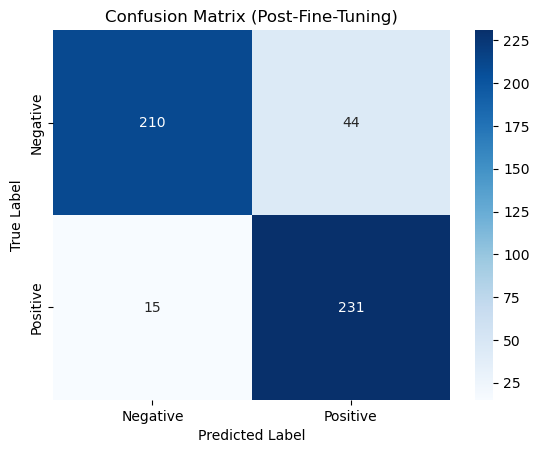

In [11]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Plot confusion matrices
print("Confusion Matrix After Fine-Tuning:")
plot_confusion_matrix(true_labels_after, predictions_after, "Confusion Matrix (Post-Fine-Tuning)")

### Generating Classification Reports

Generate a classification report to get detailed performance metrics (precision, recall, F1-score).

In [12]:
from sklearn.metrics import classification_report

# Print classification report before and after fine-tuning
print("\nClassification Report After Fine-Tuning:")
print(classification_report(true_labels_after, predictions_after, target_names=["Negative", "Positive"]))


Classification Report After Fine-Tuning:
              precision    recall  f1-score   support

    Negative       0.93      0.83      0.88       254
    Positive       0.84      0.94      0.89       246

    accuracy                           0.88       500
   macro avg       0.89      0.88      0.88       500
weighted avg       0.89      0.88      0.88       500

